In [ ]:
!apt-get install -y dotnet-sdk-8.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
dotnet-sdk-8.0 is already the newest version (8.0.103-0ubuntu1~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!apt-get install -y aspnetcore-runtime-8.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
aspnetcore-runtime-8.0 is already the newest version (8.0.3-0ubuntu1~22.04.2).
aspnetcore-runtime-8.0 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!apt-get install -y dotnet-runtime-8.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
dotnet-runtime-8.0 is already the newest version (8.0.3-0ubuntu1~22.04.2).
dotnet-runtime-8.0 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install nsepython
!pip install plotly
!pip install stock_indicators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.0/291.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
import datetime
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from nsepython import *

import plotly.graph_objects as go

from stock_indicators import indicators, Quote

In [ ]:
class StockData:
    """
    We use this class to get data for a given stock
    """
    def __init__(self, symbol="SBIN"):
        self.set_symbol(symbol)
        self.series = "EQ"


    def set_symbol(self, symbol):
        """
        Set the stock symbol. This symbol will be used to perform queries
        symbol: stock symbol
        """
        self.symbol = symbol


    def set_history_duration(self, days=365):
        """
        Based on the days parameter, we fetch historical data from nse. By default we perform query for 365 days
        """
        self.history_duration = days
        end_data = datetime.datetime.now().strftime("%d-%m-%Y")
        self.end_date = str(end_data)
        self.start_data = (datetime.datetime.now() - datetime.timedelta(days=days)).strftime("%d-%m-%Y")


    def fetch_data(self):
        """
        Fetch the historic data associated with the stock symbol
        """
        self.stock_df = equity_history(self.symbol, self.series, self.start_data, self.end_date)
        #!!! We may need to normalize the mean to ZERO !!!


    def normalize_data(self):
        """
        Normalize the mean to ZERO
        :return:
        """
        self.stock_df['Close'] = self.stock_df['Close']


    def update_quotes(self):
        """
        Update the quote list needed for generating indicators
        :return:
        """
        datetime_list = []
        for date_str in self.stock_df['CH_TIMESTAMP']:
            year, month, date = re.findall("(\d+)-(\d+)-(\d+)", date_str)[0]
            datetime_list.append(datetime.datetime(int(year), int(month), int(date), 0, 0, 0))

        self.quotes_list = [ Quote(date, open, high, low, close, volume)
                             for date, open, high, low, close, volume
                             in zip(datetime_list, self.stock_df['CH_OPENING_PRICE'], self.stock_df['CH_TRADE_HIGH_PRICE'],
                                    self.stock_df['CH_TRADE_LOW_PRICE'], self.stock_df['CH_CLOSING_PRICE'], self.stock_df['CH_TOT_TRADED_QTY'])
                             ]

    def generate_macd_indicators(self):
        """
        generate the macd indicator for the stocks
        :return:
        """
        macd_results = indicators.get_macd(self.quotes_list, 12, 26, 9)
        self.macd_data = [r.macd for r in macd_results]


    def generate_bolinger_band_indicators(self):
        """
        generate the bolinger band indicator for the stocks
        :return:
        """
        self.bolinger_band_data = {}
        bolinger_band_results = indicators.get_bollinger_bands(self.quotes_list, 20, 2)
        self.bolinger_band_data["sma"] = [r.sma for r in bolinger_band_results]
        self.bolinger_band_data["lower_band"] = [r.lower_band for r in bolinger_band_results]
        self.bolinger_band_data["upper_band"] = [r.upper_band for r in bolinger_band_results]


    def generate_rsi_indicators(self):
        """
        generate the rsi indicator for the stocks
        :return:
        """
        rsi_results = indicators.get_rsi(self.quotes_list, 14)
        self.rsi_data = [r.rsi for r in rsi_results]


    def generate_indicators(self):
        """
        Generate various indicators from the captured stock data
        :return:
        """
        self.update_quotes()
        self.generate_macd_indicators()
        self.generate_bolinger_band_indicators()
        self.generate_rsi_indicators()

        self.all_inds = pd.DataFrame(self.bolinger_band_data, dtype=np.float32)
        self.all_inds['rsi'] = self.rsi_data
        self.all_inds['macd'] = self.macd_data
        self.all_inds.dropna(inplace=True)
        self.all_inds.reset_index(drop=True, inplace=True)
        self.all_inds = self.all_inds[::-1]
        return


    def plot_data(self):
        """
        Plots the stock data
        """
        fig = go.Figure(data=[go.Candlestick(x=self.stock_df['CH_TIMESTAMP'],
                                             open=self.stock_df['CH_OPENING_PRICE'],
                                             high=self.stock_df['CH_TRADE_HIGH_PRICE'],
                                             low=self.stock_df['CH_TRADE_LOW_PRICE'],
                                             close=self.stock_df['CH_CLOSING_PRICE'])])

        fig.show()

In [ ]:
stock_obj = StockData("SBIN")
stock_obj.set_history_duration(365)
stock_obj.fetch_data()
# stock_obj.plot_data() # this is needed only to visualize the data
stock_obj.generate_indicators()

{'data': [{'_id': '6481c2fe185a550007a782aa', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 593.95, 'CH_TRADE_LOW_PRICE': 586.35, 'CH_OPENING_PRICE': 589.95, 'CH_CLOSING_PRICE': 588.5, 'CH_LAST_TRADED_PRICE': 588, 'CH_PREVIOUS_CLS_PRICE': 589.2, 'CH_TOT_TRADED_QTY': 15971917, 'CH_TOT_TRADED_VAL': 9442724430.85, 'CH_52WEEK_HIGH_PRICE': 629.55, 'CH_52WEEK_LOW_PRICE': 430.7, 'CH_TOTAL_TRADES': 140988, 'CH_ISIN': 'INE062A01020', 'CH_TIMESTAMP': '2023-06-08', 'TIMESTAMP': '2023-06-07T18:30:00.000Z', 'createdAt': '2023-06-08T12:01:02.557Z', 'updatedAt': '2023-06-08T12:01:02.557Z', '__v': 0, 'SLBMH_TOT_VAL': None, 'VWAP': 591.21, 'mTIMESTAMP': '08-Jun-2023'}, {'_id': '6480717e6cfb2d00070b78fe', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 590.6, 'CH_TRADE_LOW_PRICE': 586, 'CH_OPENING_PRICE': 588, 'CH_CLOSING_PRICE': 589.2, 'CH_LAST_TRADED_PRICE': 588.8, 'CH_PREVIOUS_CLS_PRICE': 585.35, 'CH_TOT_TRADED_QTY': 111137

In [ ]:
stock_obj.all_inds

,sma,lower_band,upper_band,rsi,macd
227,767.682495,736.112183,799.252808,64.736745,11.087031
226,764.282471,733.284973,795.280029,70.694010,9.402749
225,760.650024,737.056396,784.243652,58.323284,5.955497
224,759.330017,735.716248,782.943726,58.281991,5.500925
223,757.895020,734.290344,781.499634,58.281991,4.850895
...,...,...,...,...,...
4,584.284973,573.473816,595.096191,46.563035,2.719523
3,584.445007,573.877197,595.012817,55.982078,3.580495
2,583.927490,573.192322,594.662720,55.982078,3.629510
1,583.174988,571.740234,594.609741,56.688334,3.639278


In [ ]:

class StockTrajectory:
    def __init__(self, stock_name):
        """
        Initialize the stock data object
        :param stock_name: stock whose data needs to monitored
        """
        self.stock_data_obj = StockData(stock_name)
        self.num_trading_days = 0


    def set_time_frame(self, duration_in_days=365):
        """
        set the past duration to capture the data
        :param duration_in_days: durations for which history data needs to be captured
        :return:
        """
        self.duration_in_days = duration_in_days


    def set_total_capital(self, capital_amount=100000):
        """
        set the total capital amount available. Either it is completely invested or completely withdrawn
        :param capital_amount: total capital
        :return:
        """
        self.capital_amount = capital_amount


    def process_data(self):
        """
        Process the data from the stock
        :return:
        """
        self.stock_data_obj.set_history_duration(self.duration_in_days)
        self.stock_data_obj.fetch_data()
        self.stock_data_obj.generate_indicators()
        self.num_trading_days = self.stock_data_obj.all_inds.shape[0]
        print(self.num_trading_days)


    def reset(self):
        """
        set the reference to the oldest record available
        :return:
        """
        self.record_idx = self.num_trading_days - 1
        self.capital_invested = 0
        self.nav_at_purchase = 0
        self.quantity = 0

        return self.stock_data_obj.all_inds.iloc[self.record_idx]


    def update_stock_params(self):
        """
        For the current record index, set the parameters associated with the stock data
        :return:
        """
        self.high_price = self.stock_data_obj.stock_df['CH_TRADE_HIGH_PRICE'][self.record_idx]
        self.low_price = self.stock_data_obj.stock_df['CH_TRADE_LOW_PRICE'][self.record_idx]
        self.open_price = self.stock_data_obj.stock_df['CH_OPENING_PRICE'][self.record_idx]
        self.close_price = self.stock_data_obj.stock_df['CH_CLOSING_PRICE'][self.record_idx]
        self.close_price_next = self.stock_data_obj.stock_df['CH_CLOSING_PRICE'][self.record_idx-1]
        self.close_price_prev = self.stock_data_obj.stock_df['CH_CLOSING_PRICE'][min(self.num_trading_days-1, self.record_idx+1)]


    def invest_capital(self, capital:float):
        """
        Invest specified capital
        :param capital: capital to invest
        :return:
        """
        # calculate the NAVs for the purchase
        self.nav_at_purchase = self.close_price
        # increment the holding quantity
        self.quantity += int(capital / self.nav_at_purchase)
        # increment the capital invested
        self.capital_invested += (self.quantity * self.nav_at_purchase)


    def withdraw_capital(self):
        """
        Currently we assume that we withdraw entire capital
        :return:
        """
        # increment the capital invested
        self.capital_invested = 0
        # calculate the NAVs for the purchase
        self.nav_at_purchase = 0
        # increment the holding quantity
        self.quantity = 0
        # set current NAV
        self.nav_at_sell = self.close_price


    def calc_reward(self):
        """
        calculate the reward due to our current action
        :return:
        """
        # next day closing price - current day closing price
        reward = self.close_price_next - self.close_price
        return reward


    def step(self, action:int):
        """
        take a step abd update the next state
        :param action: (SELL, HOLD, BUY) which maps to (-1, 0, 1)
        :return: reward calculated as next_day_closing - current_day_closing
        """
        # as we are considering single time lumpsum investment/withdrawal, buy/hold have same return.
        self.update_stock_params()

        # this can be modified late based on the use-case
        if action == 1: # BUY
            self.invest_capital(self.capital_amount)
        elif action == -1: # SELL
            self.withdraw_capital()

        reward = self.calc_reward()
        # scale reward to number to quantities purchased
        reward_scaled = reward * self.quantity

        # decrement the record index to next date
        self.record_idx -= 1

        done = (self.record_idx==0)
        # print(done, self.record_idx)

        next_state = (self.stock_data_obj.all_inds.iloc[self.record_idx] if not done else None)

        return reward_scaled, next_state, done

{'data': [{'_id': '63ce8e3dea62a90007764f9f', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 475.55, 'CH_TRADE_LOW_PRICE': 463.2, 'CH_OPENING_PRICE': 466.6, 'CH_CLOSING_PRICE': 471.3, 'CH_LAST_TRADED_PRICE': 471, 'CH_PREVIOUS_CLS_PRICE': 463.4, 'CH_TOT_TRADED_QTY': 17168871, 'CH_TOT_TRADED_VAL': 8079264816.6, 'CH_52WEEK_HIGH_PRICE': 549, 'CH_52WEEK_LOW_PRICE': 400.5, 'CH_TOTAL_TRADES': 192002, 'CH_ISIN': 'INE062A01020', 'CH_TIMESTAMP': '2022-06-08', 'TIMESTAMP': '2022-06-07T18:30:00.000Z', 'createdAt': '2023-01-23T13:40:13.375Z', 'updatedAt': '2023-01-23T13:40:13.375Z', '__v': 0, 'SLBMH_TOT_VAL': None, 'VWAP': 470.58, 'mTIMESTAMP': '08-Jun-2022'}, {'_id': '63ce8e2e989df5000759d41b', 'CH_SYMBOL': 'SBIN', 'CH_SERIES': 'EQ', 'CH_MARKET_TYPE': 'N', 'CH_TRADE_HIGH_PRICE': 465.95, 'CH_TRADE_LOW_PRICE': 460.5, 'CH_OPENING_PRICE': 461.85, 'CH_CLOSING_PRICE': 463.4, 'CH_LAST_TRADED_PRICE': 463.95, 'CH_PREVIOUS_CLS_PRICE': 463.7, 'CH_TOT_TRADED_QTY': 767251

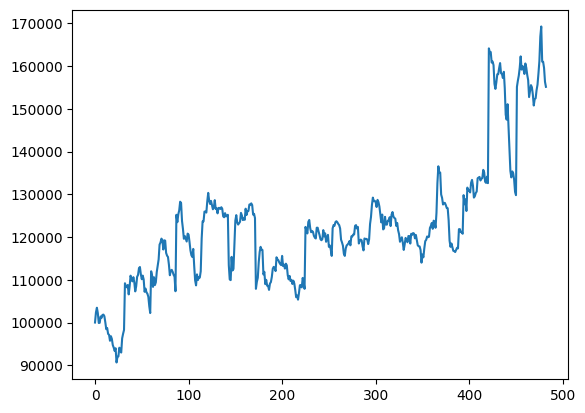

In [ ]:
trajectory_obj = StockTrajectory("SBIN")
trajectory_obj.set_time_frame(730)
trajectory_obj.set_total_capital(100000)
trajectory_obj.process_data()
trajectory_obj.reset()

cumulative_reward = 0
return_trajectory = [100000]

reward, next_state, done = trajectory_obj.step(1)
print(reward)
return_trajectory.append(return_trajectory[-1]+reward)
cumulative_reward += reward
done = False
while not done:
    reward, next_state, done = trajectory_obj.step(0)
    return_trajectory.append(return_trajectory[-1] + reward)
    cumulative_reward += reward

plt.plot(return_trajectory)
plt.show()